In [ ]:
pip install pandas numpy matplotlib seaborn torch transformers wordcloud scikit-learn
%pip install fitz frontend


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import fitz  # PyMuPDF


In [ ]:
%pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.4 MB/s eta 0:00:00:00:0100:01


In [28]:
def parse_pdf_to_string(pdf_path):
    try:
        # Open the PDF file
        doc = fitz.open(pdf_path)
        text_content = ""
        
        # Iterate through each page in the PDF
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text_content += page.get_text()

        # Close the document
        doc.close()

        # Perform post-processing on the extracted text
        # Remove multiple spaces and new lines to form a single string
        formatted_text = ' '.join(text_content.split())

        # Return the formatted string
        return formatted_text

    except Exception as e:
        print(f"An error occurred while processing the PDF: {e}")
        return None


An error occurred while processing the PDF: no such file: 'C:/Users/Aneesh Raskar/OneDrive/Desktop/NLP Based Resume Parser/model/Sahil Khodke - Resume.pdf'
None


In [7]:
# Load the dataset
df = pd.read_csv('/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv')  # Adjust the file path if needed

# Display the first few rows
df.head()


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


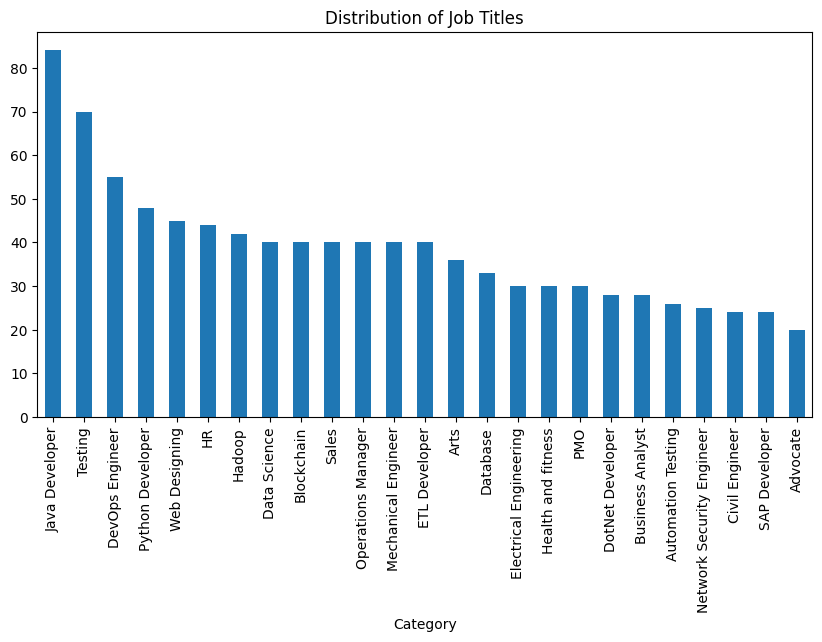

In [8]:
# Check for null values
df.isnull().sum()

# Fill or drop missing values
df.dropna(inplace=True)

# Encode labels
df['Category'] = df['Category'].astype('category')
df['label'] = df['Category'].cat.codes

# Check the distribution of labels
df['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Job Titles')
plt.show()

# Split the data into training and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Resume'], df['label'], test_size=0.2, random_state=42
)


In [9]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Tokenize and encode texts
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)

# PyTorch Dataset class
class ResumeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = ResumeDataset(train_encodings, train_labels)
val_dataset = ResumeDataset(val_encodings, val_labels)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Category'].unique()))

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 3  # 3 epochs
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 / 10
Training Loss: 2.531
Validation Loss: 1.203
Epoch 2 / 10
Training Loss: 0.636
Validation Loss: 0.270
Epoch 3 / 10
Training Loss: 0.249
Validation Loss: 0.181
Epoch 4 / 10
Training Loss: 0.215
Validation Loss: 0.181
Epoch 5 / 10
Training Loss: 0.214
Validation Loss: 0.181
Epoch 6 / 10
Training Loss: 0.218
Validation Loss: 0.181
Epoch 7 / 10
Training Loss: 0.215
Validation Loss: 0.181
Epoch 8 / 10
Training Loss: 0.216
Validation Loss: 0.181
Epoch 9 / 10
Training Loss: 0.215
Validation Loss: 0.181
Epoch 10 / 10
Training Loss: 0.215
Validation Loss: 0.181


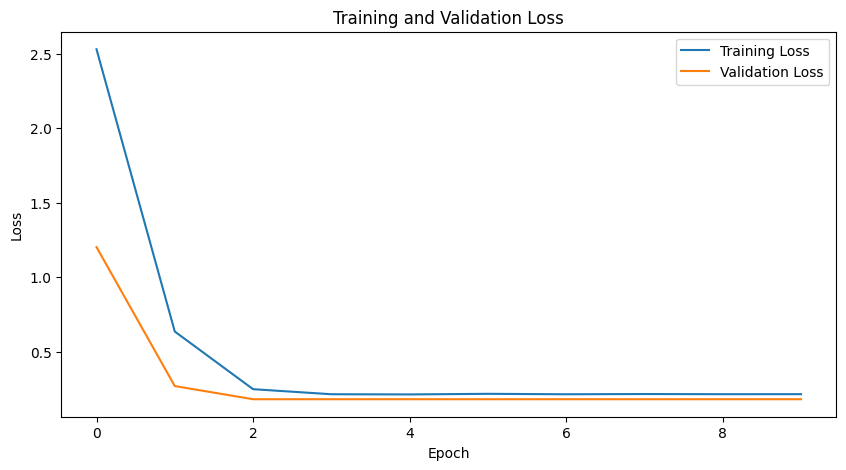

In [12]:
# Training function
def train_model():
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

# Evaluation function
def evaluate_model():
    model.eval()
    total_eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

    avg_val_loss = total_eval_loss / len(val_loader)
    return avg_val_loss, predictions, true_labels

# Training loop
train_losses, val_losses = [], []

for epoch in range(10):
    print(f"Epoch {epoch + 1} / 10")
    train_loss = train_model()
    val_loss, predictions, true_labels = evaluate_model()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Training Loss: {train_loss:.3f}")
    print(f"Validation Loss: {val_loss:.3f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      1.00      1.00        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       1.00      1.00      1.00     

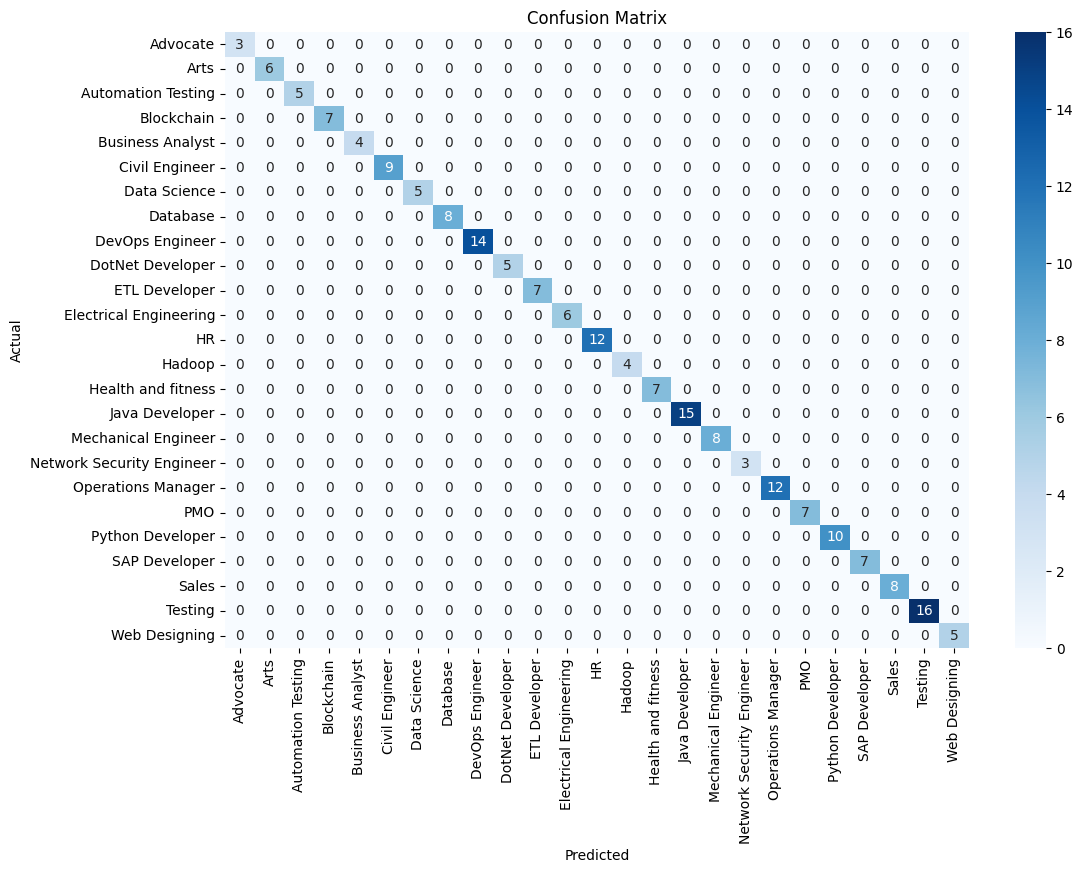

In [13]:
# Classification report
print(classification_report(true_labels, predictions, target_names=df['Category'].cat.categories))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['Category'].cat.categories, yticklabels=df['Category'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


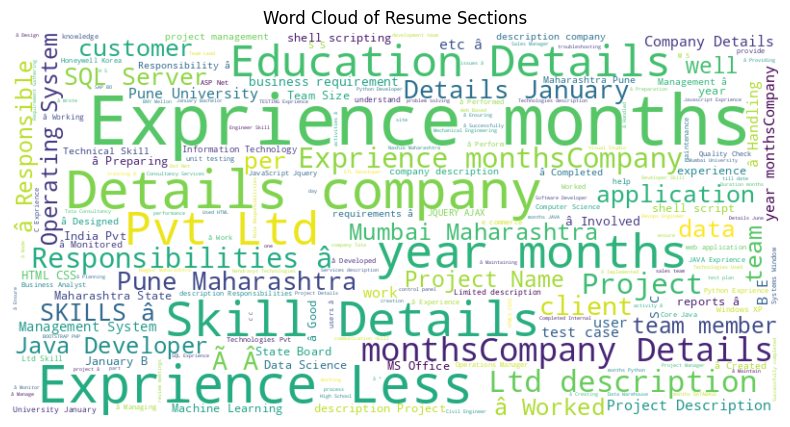

In [14]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Resume']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Resume Sections')
plt.show()


In [16]:
# Save the trained model using Hugging Face's save_pretrained method
model_save_path = './bert_resume_classification_model'
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to ./bert_resume_classification_model


In [17]:
from transformers import TFBertForSequenceClassification

# Load the model using Hugging Face's from_pretrained method
loaded_model = TFBertForSequenceClassification.from_pretrained(model_save_path)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [19]:
import tensorflow as tf
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    return predicted_class

# Test the prediction with a new resume
input_string = "Aneesh Raskar * Pune, Maharashtra, India # aneeshraskar@gmail.com | +91-7666821785 | My Portfolio | ï Linkedin | § Github Education Vellore Institute of Technology, Chennai, B.Tech in Computer Science with Specialization in AI and ML Sept 2021 – Present CGPA: 8.07 Experience AI ML Intern, WIT Solutions, Pune Sept 2023 – Dec 2023 • Significantly contributed to a Diabetic Retinopathy project by engineering a high-performance Exception-V3 model, achieving a state-of-the-art 93% accuracy on the IDRiD dataset. • This project elevated the sake of simplicity of the company by 15% Board Member, HackClub - VITC, Chennai Jan 2023 – June 2024 • Coordinated the administration and preparation over 10 events and 4 hackathons, actively boosting community engagement and promoting collaboration with other technical clubs in campus. • Promoted from management team member to management lead in July 2023, then to board in Jan 2024. Member of Electrical Dept., Dreadnought Robotics - VITC, Chennai Sept 2022 – Apr 2024 • Engineered and optimized 3+ autonomous robots, leading the team to secure top positions in 2 inter-college robotics competitions, showcasing exceptional innovation and technical prowess • Contributed in the building of AUV which qualified 2nd in TAC Challenge - 2024, Norway Publications Advancing IoT Interoperability: Dynamic Protocol Translation through Machine Learning for Enhanced Communication Efficiency 10.36948/ijfmr.2024.v06i04.24869 July 2024 Neeta Lokhande, Rajendra Agrawal, Aneesh Raskar Waste Management Optimization Using Reinforcement Learning Algorithm Journal of Innovations in Data Science and Big Data Management, 3(2), 1–10. May 2024 Neeta Lokhande, Aneesh Raskar Projects Computational Offloading using Deep Learning | Python, TensorFlow Live • To optimize process distribution by conducting a comprehensive analysis of workload characteristics, resource utilization, and network bandwidth constraints to maximize system efficiency and performance. Real-Time Crime Detection using Deep Learning | Python, TensorFlow, Open-CV GitHub • Designed a deep neural network utilizing Long Short-Term Memory architecture to effectively recognize and classify criminal activities within CCTV video streams, achieving a precision score of 87% and recall rate of 84%. Energy-Efficient Smart Irrigation System | Python, SciKit-Learn, Arduino, Blynk GitHub • Engineered an advanced IoT irrigation solution leveraging real-time sensor data and decision tree algorithms, achieving water conservation and optimizing crop yield significantly improving agricultural efficiency by 89%. Technologies Languages: C++, C, Java, Python, MongoDB, SQL, JavaScript, Node,js, HTML, CSS Frameworks: TensorFlow, PyTorch, Open-CV, SciKit-Learn, React.js, Flask, Arduino, Git, GitHub"
result = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {result}")


Predicted class: 6


In [21]:
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    # Get the corresponding job role from the Category column
    predicted_job_role = df['Category'].cat.categories[predicted_class]
    
    return predicted_class, predicted_job_role

# Test the prediction with a new resume
input_string = "Aneesh Raskar * Pune, Maharashtra, India # aneeshraskar@gmail.com | +91-7666821785 | My Portfolio | ï Linkedin | § Github Education Vellore Institute of Technology, Chennai, B.Tech in Computer Science with Specialization in AI and ML Sept 2021 – Present CGPA: 8.07 Experience AI ML Intern, WIT Solutions, Pune Sept 2023 – Dec 2023 • Significantly contributed to a Diabetic Retinopathy project by engineering a high-performance Exception-V3 model, achieving a state-of-the-art 93% accuracy on the IDRiD dataset. • This project elevated the sake of simplicity of the company by 15% Board Member, HackClub - VITC, Chennai Jan 2023 – June 2024 • Coordinated the administration and preparation over 10 events and 4 hackathons, actively boosting community engagement and promoting collaboration with other technical clubs in campus. • Promoted from management team member to management lead in July 2023, then to board in Jan 2024. Member of Electrical Dept., Dreadnought Robotics - VITC, Chennai Sept 2022 – Apr 2024 • Engineered and optimized 3+ autonomous robots, leading the team to secure top positions in 2 inter-college robotics competitions, showcasing exceptional innovation and technical prowess • Contributed in the building of AUV which qualified 2nd in TAC Challenge - 2024, Norway Publications Advancing IoT Interoperability: Dynamic Protocol Translation through Machine Learning for Enhanced Communication Efficiency 10.36948/ijfmr.2024.v06i04.24869 July 2024 Neeta Lokhande, Rajendra Agrawal, Aneesh Raskar Waste Management Optimization Using Reinforcement Learning Algorithm Journal of Innovations in Data Science and Big Data Management, 3(2), 1–10. May 2024 Neeta Lokhande, Aneesh Raskar Projects Computational Offloading using Deep Learning | Python, TensorFlow Live • To optimize process distribution by conducting a comprehensive analysis of workload characteristics, resource utilization, and network bandwidth constraints to maximize system efficiency and performance. Real-Time Crime Detection using Deep Learning | Python, TensorFlow, Open-CV GitHub • Designed a deep neural network utilizing Long Short-Term Memory architecture to effectively recognize and classify criminal activities within CCTV video streams, achieving a precision score of 87% and recall rate of 84%. Energy-Efficient Smart Irrigation System | Python, SciKit-Learn, Arduino, Blynk GitHub • Engineered an advanced IoT irrigation solution leveraging real-time sensor data and decision tree algorithms, achieving water conservation and optimizing crop yield significantly improving agricultural efficiency by 89%. Technologies Languages: C++, C, Java, Python, MongoDB, SQL, JavaScript, Node,js, HTML, CSS Frameworks: TensorFlow, PyTorch, Open-CV, SciKit-Learn, React.js, Flask, Arduino, Git, GitHub"
predicted_class, predicted_job_role = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {predicted_class}")
print(f"Predicted job role: {predicted_job_role}")


Predicted class: 6
Predicted job role: Data Science


In [22]:
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    # Get the corresponding job role from the Category column
    predicted_job_role = df['Category'].cat.categories[predicted_class]
    
    return predicted_class, predicted_job_role

# Test the prediction with a new resume
input_string = "Harsh Tembhurnikar Corporation Colony, Nagpur  +917758975599 # harsht1326@gmail.com ï linkedin.com/in/harsh § github.com/harsh Education Vellore Institute of Technology Sep. 2021 – May 2025 Bachelor of Technology - Information Technology; CGPA: 8.3 Chennai, Tamil Nadu Nutan Bharat Vidyalaya Jun. 2019 – Mar. 2021 Higher Secondary Schooling; 92% Nagpur, Maharashtra Technical Skills Frontend: HTML, CSS, Bootstrap, React.js, JavaScript, TypeScript Backend: Node.js, Express.js, GO, React.js, kafka, Cassandra Devops: AWS, Jenkins, Ansible, Docker, Kubernetes, Terraform, Nagios, HAProxy, Prometheus, Grafana, SonarQube Tools: Postman, Git, Github, Canva, Knowledge: Blockchain basics(Solana, Ethereum), Ai&Ml Experience Informatrix Solutions Pvt. Ltd. Aug 2023 – Mar 2024 Cloud (DevOps) Engineer Intern Nagpur, Maharashtra • Containerization & Orchestration: Successfully containerized with Docker and orchestrated with Kubernetes for complex applications across multiple cloud platforms. • Developed and maintained CI/CD pipelines, resulting in a 30% reduction in deployment times and least human error. • Implemented advanced monitoring and logging solutions using tools like Promethues and Grafana, providing real-time insights and active alerts to ensure system stability and security. • Led root cause analysis for post-implementation issues for automating the process with Terraform and Ansible, working closely with engineering and product management teams to resolve customer problems permanently in virtual enviornment(VMware). • Provide support on weekdays and Off hours, going above and beyond to support their business needs in Linux enviornment and ensuring the highest levels of satisfaction with the communication and analytics skills. • Monitored the quality of code with help of SonarQube and Trivy to have the code quality, security and scanning of the code. Putra.in Jan 2022 – Mar 2022 Ful-lStack Developer Remote • Designed and developed a visually appealing and efficient company website using HTML, CSS/Bootstrap, JavaScript, jQuery, Node.js, MongoDB/MySQL, Express.js, and AWS Cloud. • Developed and deployed cloud infrastructure tailored to reduce 25% customer requirements, including networking, storage, and compute resources. • Played a key role in developing and deploying applications, ensuring alignment with customer needs and industry best practices to achieve 10% growth in the bussiness. • Set up comprehensive monitoring and logging facilities, including active alerts on the admin panel, to ensure continuous system health and proactive issue resolution. Projects Azure CI/CD Pipeline using Azure Pipelines and Argo CD Multi Microservice | Azure Pipelines, Argo CD, Kubernetes, Dcoker, Ansible, GitHub, GitOps Medium • Optimized Argo CD integration, boosting real-time synchronization by 50% and minimizing system downtime. • Streamlined stage testing environments, improving efficiency by 30% and reducing production issues. • Automated Kubernetes manifest updates, achieving consistent, error-free deployments with drift correction. • Enhanced security by implementing imagePullSecrets and tokens, securing Kubernetes and ACR access. • Cut cloud infrastructure costs by 40% through resource optimization in container orchestration. • Improved system security, integrating encrypted secrets management in Argo CD, reducing unauthorized access by 60%. • Strengthened infrastructure provisioning and network configuration with Ansible, enabling complex deployments and improved application connectivity. ProMonitor | Prometheus, Grafana, Linux, PromQL, YAML GitHub • Set up Prometheus for comprehensive full-stack monitoring applications, including service discovery, alerting, and network monitoring. • Implemented Grafana dashboards, enabling real-time data visualization and enhancing system observability. • Automated deployment with systemd services, optimizing workflows for scalable Linux environments. • Reduced latency by 15%, improving overall system performance. GO components with GRPC | GO, Caching, Load balancing , Rate Limiting, JWT GitHub • Designed a secure API gateway using Go, improving system reliability by 40% with JWT, rate limiting, and load balancing. • Boosted search functionality, decreasing data retrieval time by 30%, improving user experience. • Diminished code errors by 35%, integrating automated testing and linting for consistency. • Refined API performance, reducing server load by 25% through caching strategies. End-to-End CI/CD Pipeline Implementation | Jenkins, Terraform, Docker, Kubernetes, SonarQube, ArgoCD AWS EC2, EKS, and Github Actions, Networking GitHub • Built and deployed a CI/CD pipeline, improving deployment efficiency by 45% using Terraform, AWS, and Jenkins. • Accelerated build times by 35%, using GitHub Actions and enhancing code quality checks with SonarQube. • Diminished environment-related issues by 40%, containerizing Django applications using Docker for seamless portability. • Abridged security risks by 20%, integrating Trivy for vulnerability scanning in Docker images. • Amplified 50% uptime improvement, deploying with Kubernetes for better application reliability. • Carried out GitOps practices, improving deployment transparency and rollback capabilities by 30% with ArgoCD. • Expanded issue detection by 40%, integrating continuous monitoring tools for stable production environments. Acitivites • Earned AWS Certified Cloud Practitioner certification, demonstrating foundational knowledge of AWS cloud services. • Strengthened my skills and earned AWS Certified Solutions Architect certification in identifying architectural trade-offs and delivering optimal cloud solutions for complex use cases. • Got 15+ completion certification in different domains. • Hobbies: Book reading, Article writing on Medium, Code reviews" 
predicted_class, predicted_job_role = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {predicted_class}")
print(f"Predicted job role: {predicted_job_role}")


Predicted class: 8
Predicted job role: DevOps Engineer


In [23]:
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    # Get the corresponding job role from the Category column
    predicted_job_role = df['Category'].cat.categories[predicted_class]
    
    return predicted_class, predicted_job_role

# Test the prediction with a new resume
input_string = "Sahil Khodke Nagpur, Maharashtra 7218613667 | sahil.khodke12@gmail.com Objective: A self-motivated and analytical B.Tech student in Computer Science Engineering specializing in Cyber Physical Systems, seeking a dynamic role in International Capital Markets. Keen on applying quantitative analysis, decision-making, and research skills to develop and execute trading strategies for the firm. Education: Vellore Institute of Technology, Chennai, TN B.Tech in Computer Science Engineering with Specialization in Cyber Physical Systems | Expected 2025 St. Paul Junior College, Nagpur, MH 12th (State Board) | 2021 The Swaminarayan School, Nagpur, MH 10th (CBSE) | 2019 Skills: • Quantitative Analysis: Strong math aptitude with experience in analyzing complex data sets and deriving insights. • Technical Skills: C, C++, Java, MySQL, PHP, Power BI, Advanced Excel • Risk Management: Proficient in assessing and managing risks to optimize performance and outcomes. • Financial Acumen: Understanding of financial markets, economic theories, and their application in capital markets. • Problem Solving & Critical Thinking: Quick thinker with proven ability to make independent decisions in competitive environments. • Market Research: Experience in researching and developing strategies using data, trends, and market sentiment analysis. Experience: K-Star Technology | May 2024 - June 2024 Web Developer Intern • Optimized client websites utilizing PHP, HTML, CSS, and JavaScript, resulting in a 40% improvement in page load times. • Developed strong problem-solving skills by identifying and rectifying issues to improve user satisfaction. Alpha Computer Academy, Nagpur IT Manager • Oversaw and managed IT operations, including software, networking, and hardware, ensuring seamless system performance. • Gained experience in managing multiple tasks under pressure, enhancing operational efficiency. Projects: • IoT-Driven Crop Watering System Designed an automatic irrigation system based on real-time data, honing skills in data analysis and real-time decision-making. Relevant Skill: Data analysis and resource optimization. • IoT-Based RFID Attendance System Automated attendance tracking using RFID, showcasing problem-solving and data management capabilities. • V-Maps for Newcomers Created a navigation tool for university campuses, demonstrating leadership and technical skills. • E-Commerce Website for Clothing Brand Developed a functional online shopping platform using HTML, CSS, and JavaScript, which improved customer engagement. Certifications: • Amazon Web Services (AWS) • C, C++, Java, SQL Training – IIT Bombay Extracurricular Activities: • National Level Hockey Player o Played for Maharashtra in the Khelo India Youth Games. o Served as captain for the district and university teams, demonstrating leadership and teamwork skills. o Awarded Best Emerging Player in 2022. Additional Strengths: • Entrepreneurial mindset with a readiness to work in a fast-paced, competitive environment. • Ability to quickly assimilate data, analyze market trends, and make informed decisions. • Strong work ethic and commitment to professional growth."
predicted_class, predicted_job_role = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {predicted_class}")
print(f"Predicted job role: {predicted_job_role}")


Predicted class: 6
Predicted job role: Data Science


In [29]:
pdf_path = "/kaggle/input/resume-pdfs/Samrat-Kumar-Gangopadhyay-Resume.pdf"
formatted_string = parse_pdf_to_string(pdf_path)
print(formatted_string)


Samrat Kumar Gangopadhyay samganguly03@gmail.com Sharjah Github 8306581802 Linkedin samdev-kypi.onrender.com/ Professional Experience 2023/08 – 2023/11 Sharjah, United Arab Emirates AI Intern Crescent Petroleum •Developed a custom chatbot using Azure OpenAI GPT, Power Virtual Agent, and Power Automate to improve user interactions and automate tasks. •Integrated CNN models in Azure Function App for image analysis, utilizing the imagededup library to identify and remove duplicate images. •Created a Power Apps application for real-time photo comparisons against images in SharePoint/Dataverse, enhancing user experience and providing practical solutions. Education 2021 – present Chennai Bachelor's degree in CSE with specialization in Artificial Intelligence and Machine Learning VELLORE INSTITUTE OF TECHNOLOGY, CHENNAI Present CGPA - 8.12 2019 – 2021 Kota, India HIGHER SECONDARY LAL BAHADUR SHASTRI SENIOR SEC SCHOOL XII - 92.6% in AISSCE Examination 2021 (CBSE BOARD EXAMINATIONS) XI - 97.6% 

In [31]:
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    # Get the corresponding job role from the Category column
    predicted_job_role = df['Category'].cat.categories[predicted_class]
    
    return predicted_class, predicted_job_role

# Test the prediction with a new resume
input_string = formatted_string
predicted_class, predicted_job_role = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {predicted_class}")
print(f"Predicted job role: {predicted_job_role}")


Predicted class: 6
Predicted job role: Data Science


In [32]:
pdf_path = "/kaggle/input/resume-pdfs/Sujay_Resume.pdf"
formatted_string = parse_pdf_to_string(pdf_path)
print(formatted_string)


Sujay Ghosh Full Stack Developer/Engineer — Kolkata,India Ó +91-9434481092 R sujayghoshcool@gmail.com ° Linkedin  Github SKILLS Languages: HTML5, CSS3, JavaScript, React.js, Node.js, TypeScript, SQL, Angular, Next.js, Liquid, TailwindCSS Technologies & Tools: Web Development, AWS, EC2, Cross Browser Compatibility, MongoDB, S3, Lambda, Front End, ES6, Unit Testing, Docker, Back End, Server Side, Firebase, CI/CD, Load Balancer, Deployment, Shopify, Liquid, Shopify APIs, Shopify Themes, Custom Plugins, and App Integrations, Ruby WORK EXPERIENCE Branddy LLC, Delaware,USA (Remote) Mar 2024 - Present Senior Full Stack Developer and Team Lead (Product Manager) • Led a team of 6 developers in the end-to-end product development process, achieving a 20% reduction in devel- opment time through effective sprint planning. • Developed and integrated APIs for various services and deployed the product on AWS, reducing costs by 30%. • Designed a top-tier UI and implemented robust security practices, e

In [33]:
# Function to predict job category for a new resume string
def predict_single_string(model, input_string, max_length=512):
    # Tokenize the input string
    inputs = tokenizer(text=input_string,
                       add_special_tokens=True,
                       padding=True,
                       truncation=True,
                       max_length=max_length,
                       return_tensors='tf',
                       return_attention_mask=True,
                       return_token_type_ids=False)
    
    # Get input_ids and attention_mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Make prediction
    predictions = model(input_ids, attention_mask=attention_mask, training=False)
    
    # Get the predicted class
    predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]
    
    # Get the corresponding job role from the Category column
    predicted_job_role = df['Category'].cat.categories[predicted_class]
    
    return predicted_class, predicted_job_role

# Test the prediction with a new resume
input_string = formatted_string
predicted_class, predicted_job_role = predict_single_string(loaded_model, input_string)

print(f"Predicted class: {predicted_class}")
print(f"Predicted job role: {predicted_job_role}")


Predicted class: 24
Predicted job role: Web Designing


In [34]:
from transformers import BertTokenizer

# Save the trained model
model_save_path = './bert_resume_classification_model'
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the tokenizer
tokenizer_save_path = './bert_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")


Model saved to ./bert_resume_classification_model
Tokenizer saved to ./bert_tokenizer


In [35]:
import shutil

# Zip the model directory
shutil.make_archive('bert_resume_classification_model', 'zip', model_save_path)

# Zip the tokenizer directory
shutil.make_archive('bert_tokenizer', 'zip', tokenizer_save_path)


'/kaggle/working/bert_tokenizer.zip'

In [36]:
from IPython.display import FileLink

# Provide links to download the zip files
display(FileLink('bert_resume_classification_model.zip'))
display(FileLink('bert_tokenizer.zip'))


/kaggle/working/bert_resume_classification_model.zip

/kaggle/working/bert_tokenizer.zip